In [97]:
import Deck 
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


""" 
USAGE: 
table = Deck.BlackJackEnv(5)
table.start_round()
table.next(0) 0 for stand, 1 for hit 2 for double down
Both start_round and next return: player hand, dealer hand, hasAce, roundStarted, reward, runningCount, hasDoubled
"""

' \nUSAGE: \ntable = Deck.BlackJackEnv(5)\ntable.start_round()\ntable.next(0) 0 for stand, 1 for hit 2 for double down\nBoth start_round and next return: player hand, dealer hand, hasAce, roundStarted, reward, runningCount, hasDoubled\n'

# Approach 1

The first approach is to incorporate the running count into the blackjack enviroment directly, and allow the q-learning agent to 'count-cards' by tracking the number of high and low counts which have exited the game (see deal_card() in deck.py). Since the running count can vary by integer amounts which leads to a very large amount of possible states, the running counts are grouped into 3 possible enviroment conditions (see get_rCount()): low count (few 10s left in deck), neutral count, and positive count (lots of 10s left in deck). 

The policy extracted from the q-learning therefore has 3 different policies for the 3 different rCount bins (and each of those 3 policies also consists of HasAce and noAce policies). A potential weakness of this approach is that by probability it is unlikely (and therefore not extremely common) for a deck to achieve a really low or high count, which means the agent will not visit those states nearly as much as neutral states in training. This will cause for more variance in the extracted policies. Approach 2 will specificly aim to solve this issue by training on decks with artificially high and low running counts. 

In [98]:

def q_solve(env, countCards):
    
    #ROWS REPRESENT PLAYER TOTALS: 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21 (18 total)
    #COLUMNS REPRESENT DEALER SHOWING: 2,3,4,5,6,7,8,9,10,11 (10 total)
    #HAS ACE: 0,1 (2 total)
    #RUNNING COUNT: 0,1,2 (3 total)
    # ACTION: HIT, STAY (2 total)
    possible_moves = [0,1,2] 
    MOVES = ['S', 'H', 'D']
    r = 18
    c = 10
    
    qVals = [] # qvals[player][dealer][hasAce][rCount][action]

    #Initializing Qvals arr 
    for i in range(r):
        q_row = []
        for j in range(c):
            q_row.append([[[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0]],[[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0]]])
        
        qVals.append(q_row)
        
    #Learning
    for _ in range(ITERATIONS):
        #Random drop on the map
        
        pl,dl,hasAce,_,reward,rCount,_ = env.start_round()
        if not countCards:
            rCount = 0

        while True:
            #If we get dropped on p or g, its a terminal state and we end trial.
            if reward != 0.0:
                qVals[pl-4][dl-2][hasAce][rCount][0] = reward
                qVals[pl-4][dl-2][hasAce][rCount][1] = reward
                qVals[pl-4][dl-2][hasAce][rCount][2] = reward
                break

            pr = random.random()
            
            action = 0
            #WIth prob EXPLORE_PROB we pick a random possible move, otherwise we pick best q
            # Might also want to add always hit under 12 rule
            if pr < EXPLORE_PROB:
                action = random.choice(possible_moves)
            else:
                best_action_q = max(qVals[pl-4][dl-2][hasAce][rCount])
                action = qVals[pl-4][dl-2][hasAce][rCount].index(best_action_q)

            
            pl_new,dl_new,hasAce_new,_,reward,rCount_new,doubled = env.next(action)
            if not countCards:
                rCount_new = 0
            #calling new_q to update current q
            q = new_q(reward,hasAce,qVals,pl,dl,rCount,pl_new,dl_new,hasAce_new,rCount_new,action,doubled)
            #Updating q in qvals arr
            qVals[pl-4][dl-2][hasAce][rCount][action] = q
            if reward != 0.0:
                break
            #Moving on if not terminal state
            pl = pl_new
            dl= dl_new
            hasAce = hasAce_new
            rCount = rCount_new

    return get_policy(qVals,countCards)


#Q learning function
def new_q(action_reward,hasAce, qVals, pl_old, dl_old,rCount, pl_new, dl_new,hasAce_new,rCount_new, movenum,doubled):
   
    old_q = qVals[pl_old-4][dl_old-2][hasAce][rCount][movenum]
    if pl_new == 21:
        best_next_q = 200.0 if doubled else 100.0
    elif pl_new > 21:
        best_next_q = -200.0 if doubled else -100.0
    else:
        best_next_q = max(qVals[pl_new-4][dl_new-2][hasAce_new][rCount_new])

    new_q = old_q + LEARNING_RATE * (action_reward + DISCOUNT_FACTOR * best_next_q - old_q)
    return new_q

#Helper function to get extract policy from qvals
def get_policy(qVals,countCards):
        MOVES = ['S', 'H', 'D']
        aces = []
        no_aces = []
        for count in range (0,3):
            ace_policy = []
            policy = []

            for i in range(4, 22):
                ace_row = []
                row = []
                for j in range(2, 12):
                    if not countCards:
                        count = 0
                    best_action_index = qVals[i-4][j-2][0][count].index(max(qVals[i-4][j-2][0][count])) 
                    best_action = MOVES[best_action_index]
                    row.append(best_action)
                    best_action_index_ace = qVals[i-4][j-2][1][count].index(max(qVals[i-4][j-2][1][count])) 
                    best_action_ace = MOVES[best_action_index_ace]
                    ace_row.append(best_action_ace)
                policy.append(row)
                ace_policy.append(ace_row)
            aces.append(ace_policy)
            no_aces.append(policy)

        

        return (no_aces, aces)

In [94]:
def map_policies(policies,countCards):
    # Constants
    player_values = list(range(4, 22))
    dealer_cards = list(range(2, 12))
    # Hard Coded Optimal Strategy for comparison with Q-learning:
    # SOURCE: https://www.blackjackapprenticeship.com/blackjack-strategy-charts/
    strat = []
    strat.append(['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'])
    strat.append(['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'])
    strat.append(['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'])
    strat.append(['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'])
    strat.append(['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'])
    strat.append(['H', 'D', 'D', 'D', 'D', 'H', 'H', 'H', 'H', 'H'])
    strat.append(['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'H', 'H'])
    strat.append(['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D'])
    strat.append(['H', 'H', 'S', 'S', 'S', 'H', 'H', 'H', 'H', 'H'])
    strat.append(['S', 'S', 'S', 'S', 'S', 'H', 'H', 'H', 'H', 'H'])
    strat.append(['S', 'S', 'S', 'S', 'S', 'H', 'H', 'H', 'H', 'H'])
    strat.append(['S', 'S', 'S', 'S', 'S', 'H', 'H', 'H', 'H', 'H'])
    strat.append(['S', 'S', 'S', 'S', 'S', 'H', 'H', 'H', 'H', 'H'])
    strat.append(['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'])
    strat.append(['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'])
    strat.append(['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'])
    strat.append(['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'])
    strat.append(['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'])
    # Insert the hardcoded optimal policy at the beginning of the list
    pols = []
    if  countCards:
        pols.append(policies[1])
        pols.append(strat)
        pols.append(policies[0])
        pols.append(policies[2])


        # Create subplots in a 2x2 layout
        fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
        axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier indexing
        
        for idx, policy in enumerate(pols):
            # Map 'H' to 0, 'S' to 1, and 'D' to 2 for numerical representation
            strategy_numerical = [[0 if cell == 'H' else 1 if cell == 'S' else 2 if cell == 'D' else cell for cell in row] for row in policy]
            strategy_df = pd.DataFrame(policy, index=player_values, columns=dealer_cards)
            strategy_df_numerical = pd.DataFrame(strategy_numerical, index=player_values, columns=dealer_cards)
            
            # Plot each heatmap in its subplot
            sns.heatmap(strategy_df_numerical, annot=strategy_df, cmap='YlGnBu', fmt='', cbar=False, ax=axes[idx])
            title = [ 'Neutral Policy','Optimal Policy', 'Policy for running count < -2', 'Policy for running count > +2'][idx]
            axes[idx].set_title(title)
            axes[idx].set_xlabel("Dealer's Face-Up Card")
            axes[idx].set_ylabel("Player's Total" if idx % 2 == 0 else "")
        
        plt.tight_layout()
        plt.show()
    else:
        pols.append(policies[1])
        pols.append(strat)
        fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharey=True)
        axes = axes.flatten()

        for idx, policy in enumerate(pols):
            # Map 'H' to 0, 'S' to 1, and 'D' to 2 for numerical representation
            strategy_numerical = [[0 if cell == 'H' else 1 if cell == 'S' else 2 if cell == 'D' else cell for cell in row] for row in policy]
            strategy_df = pd.DataFrame(policy, index=player_values, columns=dealer_cards)
            strategy_df_numerical = pd.DataFrame(strategy_numerical, index=player_values, columns=dealer_cards)
            
            # Plot each heatmap in its subplot
            sns.heatmap(strategy_df_numerical, annot=strategy_df, cmap='YlGnBu', fmt='', cbar=False, ax=axes[idx])
            title = [ 'Q-Learning Policy','Optimal Policy'][idx]
            axes[idx].set_title(title)
            axes[idx].set_xlabel("Dealer's Face-Up Card")
            axes[idx].set_ylabel("Player's Total" if idx % 2 == 0 else "")



In [99]:
def try_policy(policy,ace_policy,countCards):
    env = Deck.BlackJackEnv(3)
    rewards = 0.0
    wins = 0
    ties = 0
    moves = {'H':1,'S':0,'D':2}
    for _ in range(200000):
        pl,dl,hasAce, _,reward,rCount,_ = env.start_round()
        if not countCards:
            rCount = 0
        while True:
            #If we get dropped on p or g, its a terminal state and we end trial.
            if reward != 0.0:
                rewards += reward
                if reward == 5.0:
                    ties += 1
                if reward > 6.0:
                    wins += 1

                break
            
            if hasAce:
                action = moves[ace_policy[rCount][pl-4][dl-2]]
            else:
                action = moves[policy[rCount][pl-4][dl-2]]
            #Take action and get new state
            
            pl, dl, hasAce, _, reward,rCount,_ = env.next(action)
            if not countCards:
                rCount = 0

    return wins/200000, ties/200000, (200000-(wins+ties))/200000,rewards/200000

    


In [52]:
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.4
EXPLORE_PROB = 0.8 # for Q-learning
ITERATIONS = 2000000
table = Deck.BlackJackEnv(3)

(no_aces,aces) = q_solve(table)

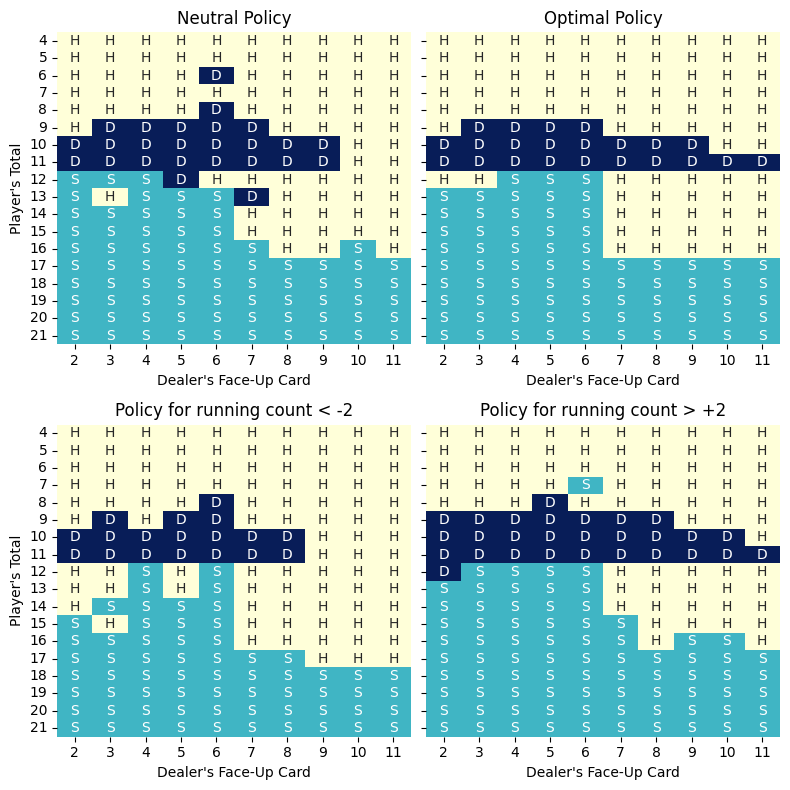

In [51]:
map_policies(no_aces)

In [71]:
try_policy(no_aces,aces)

(0.436085, 0.084755, -2.021725)

Winrate:  0.43367
Tie rate:  0.08897
Loss rate:  0.47736
Average reward:  -2.50665


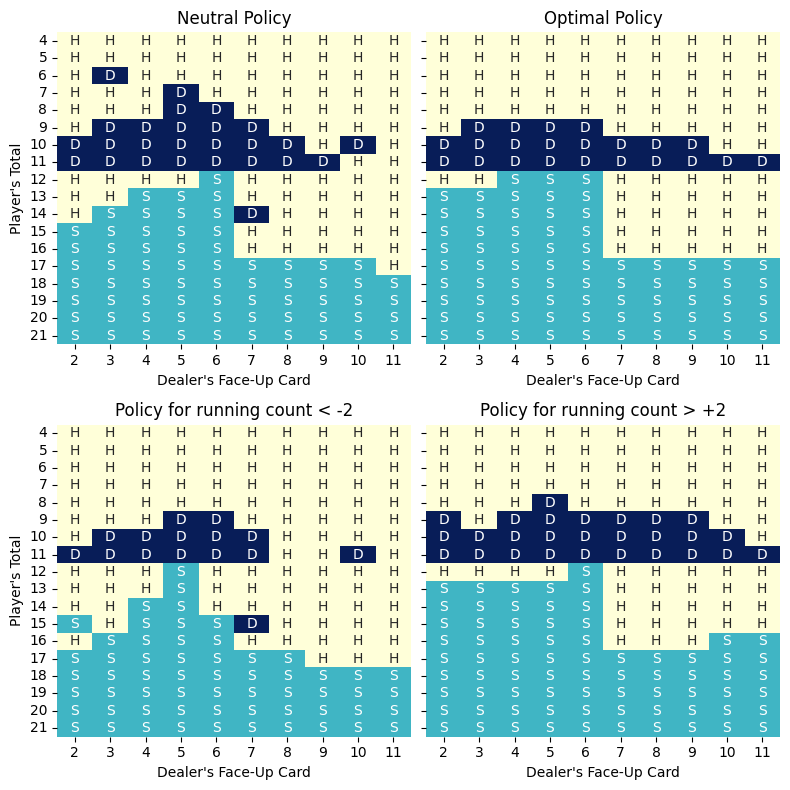

In [100]:
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.5
EXPLORE_PROB = 0.5 # for Q-learning
ITERATIONS = 2000000
table = Deck.BlackJackEnv(2)

(no_aces,aces) = q_solve(table,True)
winrate,tierate, lossrate, avg_reward = try_policy(no_aces,aces,True)
print("Winrate: ", winrate)
print("Tie rate: ", tierate)
print("Loss rate: ", lossrate)
print("Average reward: ", avg_reward)
map_policies(no_aces,True)

Winrate:  0.434205
Tie rate:  0.085695
Loss rate:  0.4801
Average reward:  -2.304025


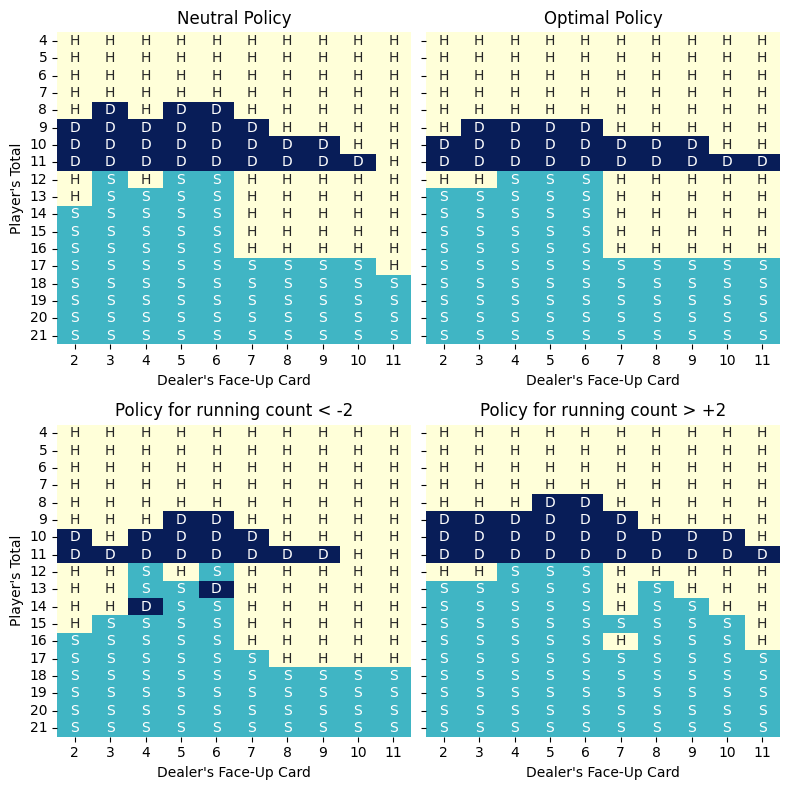

In [101]:
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.45
EXPLORE_PROB = 0.8 # for Q-learning
ITERATIONS = 20000000
table = Deck.BlackJackEnv(2)

(no_aces,aces) = q_solve(table,True)
winrate,tierate, lossrate, avg_reward = try_policy(no_aces,aces,True)
print("Winrate: ", winrate)
print("Tie rate: ", tierate)
print("Loss rate: ", lossrate)
print("Average reward: ", avg_reward)
map_policies(no_aces,True)

Winrate:  0.43182
Tie rate:  0.089065
Loss rate:  0.479115
Average reward:  -2.625175


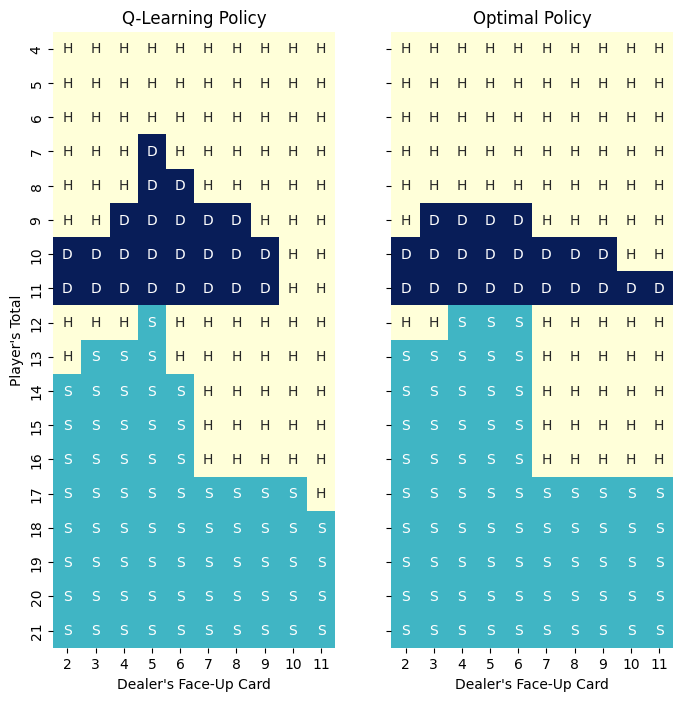

In [96]:
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.5
EXPLORE_PROB = 0.5 # for Q-learning
ITERATIONS = 2000000
table = Deck.BlackJackEnv(2)

(no_aces,aces) = q_solve(table,False)
winrate,tierate, lossrate, avg_reward = try_policy(no_aces,aces,False)
print("Winrate: ", winrate)
print("Tie rate: ", tierate)
print("Loss rate: ", lossrate)
print("Average reward: ", avg_reward)
map_policies(no_aces,False)